# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import antropy
import os
import warnings

# Ignore warnings of a specific type (DeprecationWarning in this case)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")

# Patient example

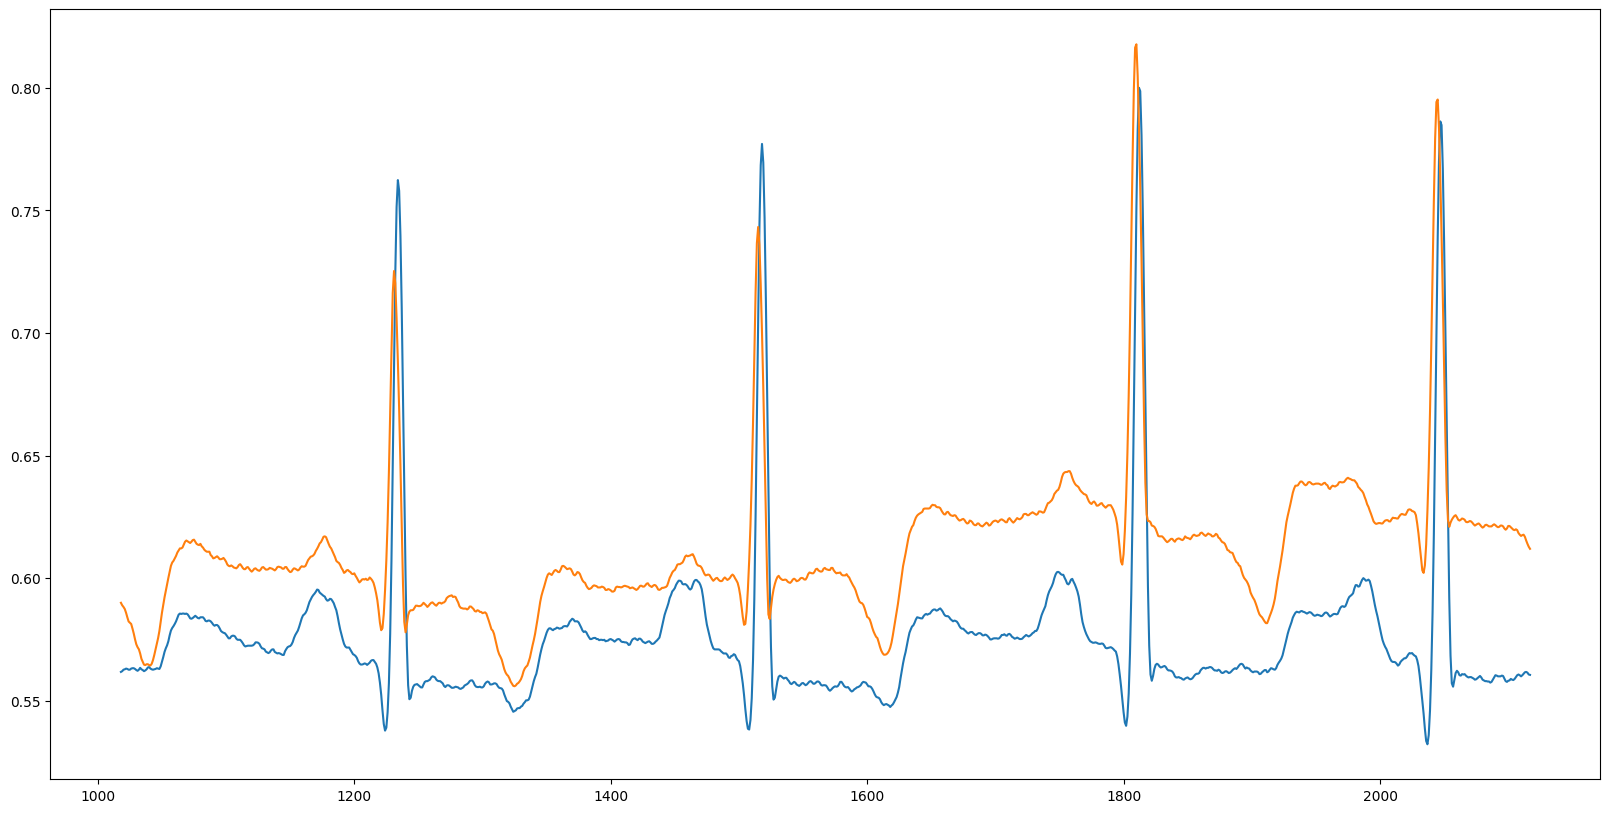

In [3]:
### Patient 100 example

# Reading ecg data
df_ecg = pd.read_csv('data/100.csv', quotechar="'")
df_ecg.rename(columns={'sample #':'Sample #'}, inplace=True)

# Reading annotations
df_annotations = pd.read_csv('data/100annotations.txt', sep='\s+')
df_annotations['Aux'] = df_annotations['Num'] 
df_annotations['Num'] = df_annotations['Chan']
df_annotations['Chan'] = df_annotations['Sub']
df_annotations['Sub'] = df_annotations['Type']
df_annotations['Type'] = df_annotations['#']
df_annotations.rename(columns={'Sample':'Sample #'}, inplace=True)
df_annotations.drop('#', axis=1, inplace=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on='Sample #', how='outer')



# Find the first row where AUX is not NaN
index_first_non_nan = df["Aux"].first_valid_index()
if index_first_non_nan is not None:
    df = df.loc[index_first_non_nan:]

# Scaling MLII and V5
scaler = MinMaxScaler()
MLII = df['MLII'].to_numpy()
V5 = df['V5'].to_numpy()
df['MLII'] = scaler.fit_transform(MLII.reshape(-1, 1))
df['V5'] = scaler.fit_transform(V5.reshape(-1, 1))

# Filtering MLII and V5 with moving average
df['MLII'] = df['MLII'].rolling(window=8, min_periods=1).mean()
df['V5'] = df['V5'].rolling(window=8, min_periods=1).mean()

df.reset_index(drop=True, inplace=True)

df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

# Plotting MLII and V5
plt.figure(figsize=(20, 10))
plt.plot(df['Sample #'][1000:2100], df['MLII'][1000:2100])
plt.plot(df['Sample #'][1000:2100], df['V5'][1000:2100])

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list = []
std_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for index, row in beat_df.iterrows():
    sample1 = int(row['sample1'])
    sample2 = int(row['sample2'])
    # Calculate mean and std values for MLII
    mean_value = df['MLII'][sample1:sample2].mean()
    std = df['MLII'][sample1:sample2].std()
    mean_list.append(mean_value)
    std_list.append(std)

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['MLII_mean'] = mean_list
beat_df['MLII_std'] = std_list

# All Patients Data Import

In [4]:
# Getting all filenames in data folder
folder_name = 'data'
folder_path = os.path.join(os.getcwd(), folder_name)
filenames = os.listdir(folder_path)

# Reading all ecg data
df_ecg = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), quotechar="'")
        df_temp.rename(columns={'sample #':'Sample #'}, inplace=True)
        df_temp.columns = df_temp.columns[:-2].tolist() + ['Signal 1', 'Signal 2']
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0]
        df_ecg = pd.concat([df_ecg, df_temp], axis=0, ignore_index=True)

# Reading all annotations
df_annotations = pd.DataFrame()
for filename in filenames:
    if filename.endswith('.txt'):
        df_temp = pd.read_csv(os.path.join(folder_path, filename), sep='\s+', engine='python')
        df_temp['Aux'] = df_temp['Num'] 
        df_temp['Num'] = df_temp['Chan']
        df_temp['Chan'] = df_temp['Sub']
        df_temp['Sub'] = df_temp['Type']
        df_temp['Type'] = df_temp['#']
        df_temp.rename(columns={'Sample':'Sample #'}, inplace=True)
        df_temp.drop('#', axis=1, inplace=True)
        # Add column to df to identify patient ID
        df_temp['Patient'] = filename.split('.')[0][0:3]
        df_annotations = pd.concat([df_annotations, df_temp], axis=0, ignore_index=True)

# Merging ecg and annotations
df = pd.merge(df_ecg, df_annotations, on=['Sample #', 'Patient'], how='outer')

# Create df_copy with only non-NaN values in Time column
df_copy = df.dropna(subset=['Time']).copy()
df_copy.reset_index(drop=True, inplace=True)

### Dataset truncation

In [5]:
# Create dataframe to truncate the data
filtered_data = pd.DataFrame()

# Iterate through each unique patient
for patient_id, group in df.groupby('Patient'):
    # Find the first row where AUX is not NaN
    index_first_non_nan = group['Aux'].first_valid_index()
    if index_first_non_nan is not None:
        filtered_data = pd.concat([filtered_data, group.loc[index_first_non_nan:]], ignore_index=True)

df = filtered_data

# Based on the time of the annotations, fill the NaN values with the previous annotation for the Type column
df['Type'] = df['Type'].fillna(method='ffill')

### Dataset information

Sample #    31197531
Signal 1    31197531
Signal 2    31197531
Patient     31197531
Time          112646
Type        31197531
Sub           112646
Chan          112646
Num           112646
Aux             1728
dtype: int64


<BarContainer object of 10 artists>

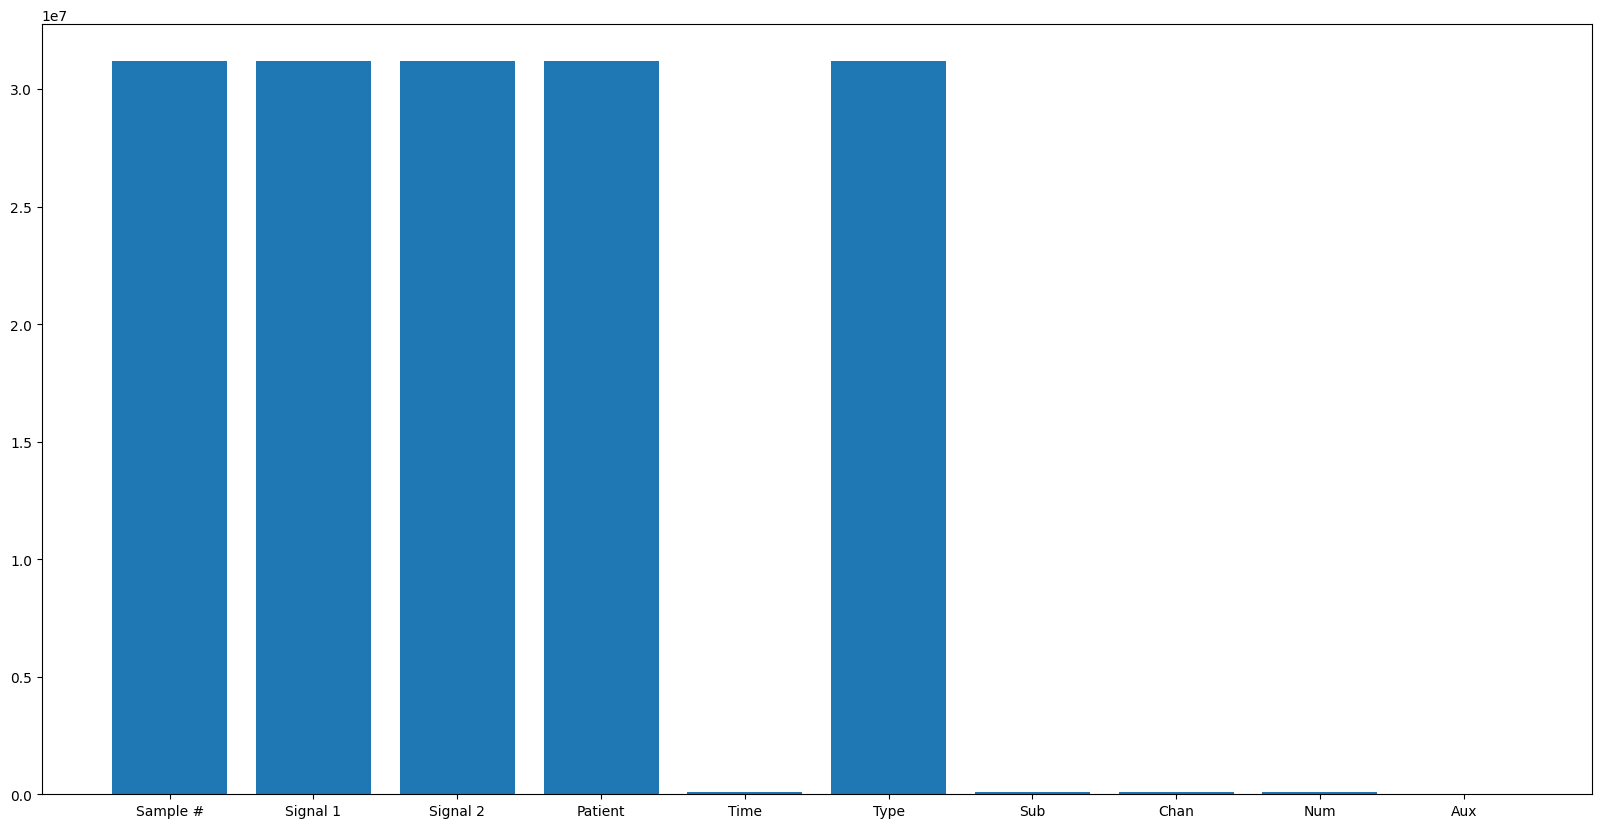

In [6]:
# For each feature count the number of non-null values
print(df.count())

# Plot each feature count in a bar plot
plt.figure(figsize=(20, 10))
plt.bar(df.columns, df.count())

In [7]:
# Print the types of each feature
print(df.dtypes)

Sample #      int64
Signal 1      int64
Signal 2      int64
Patient      object
Time         object
Type         object
Sub         float64
Chan        float64
Num         float64
Aux          object
dtype: object


In [8]:
df.describe()

,Sample #,Signal 1,Signal 2,Sub,Chan,Num
count,3.119753e+07,3.119753e+07,3.119753e+07,112646.000000,112646.0,112646.0
mean,3.250252e+05,9.562826e+02,1.001037e+03,0.062603,0.0,0.0
std,1.876240e+05,9.447422e+01,8.981329e+01,0.406945,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,0.0,0.0
25%,1.625380e+05,9.070000e+02,9.510000e+02,0.000000,0.0,0.0
50%,3.250250e+05,9.650000e+02,1.019000e+03,0.000000,0.0,0.0
75%,4.875120e+05,9.950000e+02,1.047000e+03,0.000000,0.0,0.0
max,6.499990e+05,2.047000e+03,2.047000e+03,9.000000,0.0,0.0


array([[<AxesSubplot: title={'center': 'Sample #'}>,
        <AxesSubplot: title={'center': 'Signal 1'}>],
       [<AxesSubplot: title={'center': 'Signal 2'}>,
        <AxesSubplot: title={'center': 'Sub'}>],
       [<AxesSubplot: title={'center': 'Chan'}>,
        <AxesSubplot: title={'center': 'Num'}>]], dtype=object)

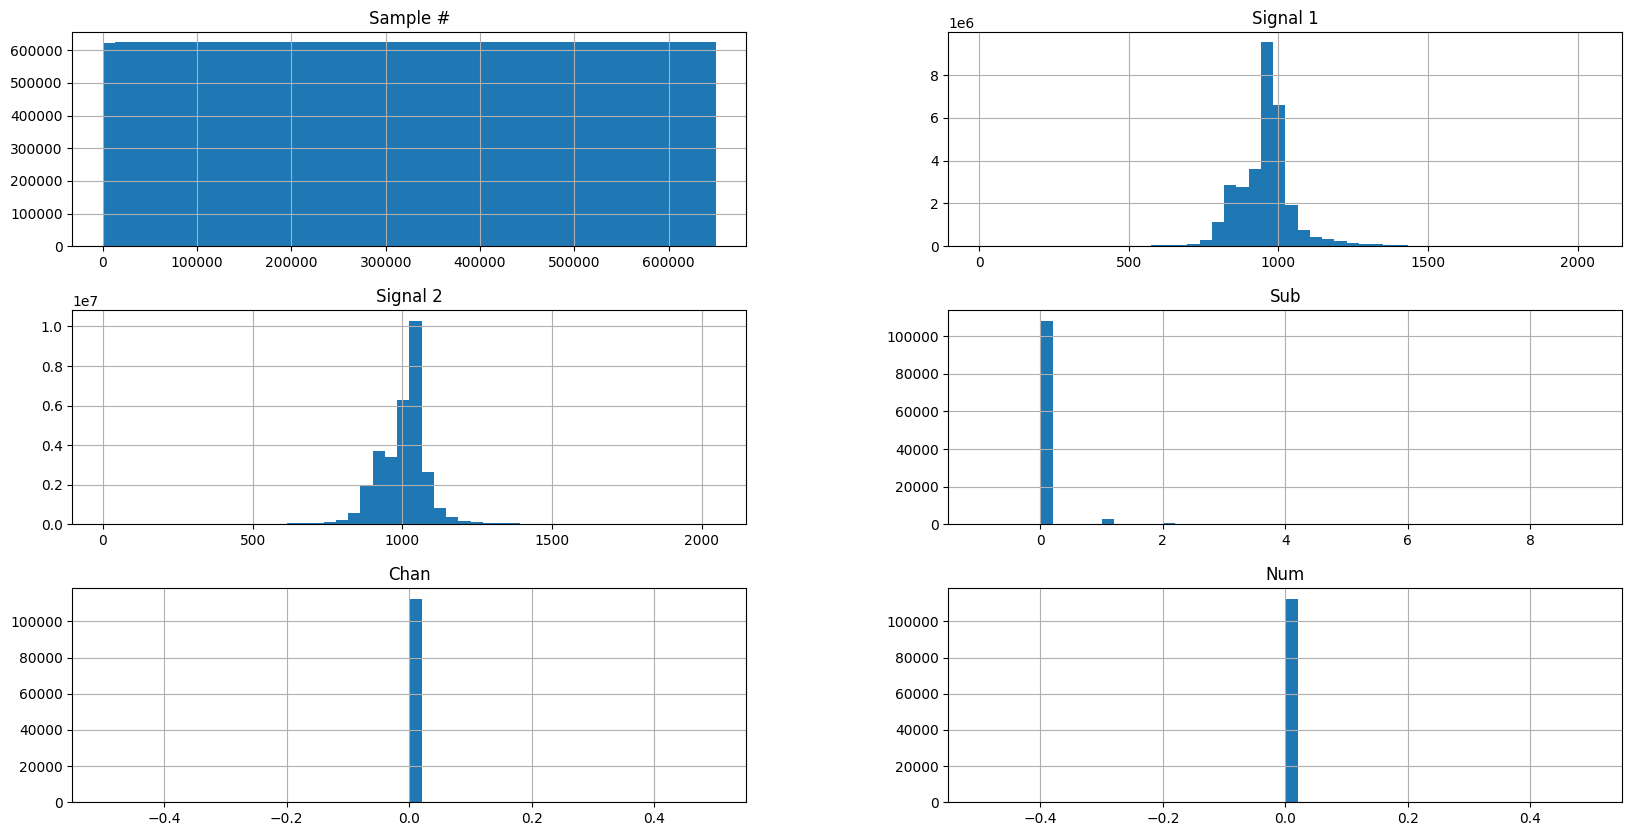

In [9]:
# Plot features histograms with the NaN values removed
df.hist(figsize=(20, 10), bins=50)

### Filtering signals

In [10]:
# Filtering signals
df['Signal 1'] = df['Signal 1'].rolling(window=5, min_periods=1).mean()
df['Signal 2'] = df['Signal 2'].rolling(window=5, min_periods=1).mean()

# Save df to csv
df.to_csv('dataframes/df.csv', index=False)

## beat_df dataframe

In [11]:
mean_list = []
std_list = []

beat_df = pd.DataFrame({
    'sample1': df_copy['Sample #'][0:-1].reset_index(drop=True),
    'sample2': df_copy['Sample #'][1:].reset_index(drop=True)})

# Add Heartbeat # column
beat_df['Heartbeat #'] = beat_df.index

# Reset the index for the new DataFrame
beat_df.reset_index(drop=True, inplace=True)

# Add a column to beat_df with the length of each heartbeat (measures were taken at 360Hz)
beat_df['RR interval'] = (beat_df['sample2'] - beat_df['sample1']) / 360

mean_list1 = []
std_list1 = []
median_list1 = []
auc_list1 = []
peak_list1 = []
valley_list1 = []
sampentropy_list1 = []
mean_list2 = []
std_list2 = []
median_list2 = []
auc_list2 = []
peak_list2 = []
valley_list2 = []
sampentropy_list2 = []
patient_list = []
type_list = []

# Look up the values for MLII and V5 in df between sample1 and sample2 in beat_df
for patient_id in df['Patient'].unique():
    print(patient_id)
    for index, row in beat_df.loc[df_copy['Patient'] == patient_id].iterrows():

        sample1 = int(row['sample1'])
        sample2 = int(row['sample2'])

        # Calculate mean, std, median, auc, peak, valley and sample entropy values for Signal 1
        mean = df['Signal 1'][sample1:sample2].mean()
        std = df['Signal 1'][sample1:sample2].std()
        median = df['Signal 1'][sample1:sample2].median()
        auc = np.trapz(y=df['Signal 1'][sample1:sample2], x=np.arange(0, (sample2 - sample1)))
        peak = df['Signal 1'][sample1:sample2].max()
        valley = df['Signal 1'][sample1:sample2].min()
        sample_entropy = antropy.sample_entropy(x=df['Signal 1'][sample1:sample2], order=2)
        mean_list1.append(mean)
        std_list1.append(std)
        median_list1.append(median)
        auc_list1.append(auc)
        peak_list1.append(peak)
        valley_list1.append(valley)
        sampentropy_list1.append(sample_entropy)

        # Calculate mean, std, median and auc values for Signal 2
        mean = df['Signal 2'][sample1:sample2].mean()
        std = df['Signal 2'][sample1:sample2].std()
        median = df['Signal 2'][sample1:sample2].median()
        auc = np.trapz(y=df['Signal 2'][sample1:sample2], x=np.arange(0, (sample2 - sample1)))
        peak = df['Signal 2'][sample1:sample2].max()
        valley = df['Signal 2'][sample1:sample2].min()
        sample_entropy = antropy.sample_entropy(x=df['Signal 2'][sample1:sample2], order=2)
        mean_list2.append(mean)
        std_list2.append(std)
        median_list2.append(median)
        auc_list2.append(auc)
        peak_list2.append(peak)
        valley_list2.append(valley)
        sampentropy_list2.append(sample_entropy)

        patient_list.append(patient_id)
        type_list.append(df_copy['Type'][index])

# Add a column to beat_df with the mean MLII and std values for each heartbeat
beat_df['Signal 1 mean'] = mean_list1
beat_df['Signal 1 std'] = std_list1
beat_df['Signal 1 median'] = median_list1
beat_df['Signal 1 auc'] = auc_list1
beat_df['Signal 1 peak'] = peak_list1
beat_df['Signal 1 valley'] = valley_list1
beat_df['Signal 1 sample entropy'] = sampentropy_list1
beat_df['Signal 2 mean'] = mean_list2
beat_df['Signal 2 std'] = std_list2
beat_df['Signal 2 median'] = median_list2
beat_df['Signal 2 auc'] = auc_list2
beat_df['Signal 2 peak'] = peak_list2
beat_df['Signal 2 valley'] = valley_list2
beat_df['Signal 2 sample entropy'] = sampentropy_list2
beat_df['Patient'] = patient_list
beat_df['Type'] = type_list

# Delete rows with RR interval < 0 seconds
beat_df = beat_df[beat_df['RR interval'] > 0]

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234


In [12]:
beat_df.head()

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 auc,Signal 1 peak,Signal 1 valley,Signal 1 sample entropy,Signal 2 mean,Signal 2 std,Signal 2 median,Signal 2 auc,Signal 2 peak,Signal 2 valley,Signal 2 sample entropy,Patient,Type
0,18,77,0,0.163889,983.555932,56.724769,965.6,57064.5,1165.0,933.8,0.092503,1007.030508,34.766409,997.2,58420.5,1117.4,971.8,0.121521,100,+
1,77,370,1,0.813889,967.148123,33.195346,960.4,282421.0,1191.8,925.2,0.068881,983.767918,19.308262,983.0,287266.4,1106.0,939.4,0.117283,100,N
2,370,662,2,0.811111,957.196575,31.293992,955.0,278555.5,1180.2,917.6,0.071186,979.156849,24.757533,981.1,284943.9,1137.2,941.8,0.072177,100,N
3,662,946,3,0.788889,954.840141,30.401054,950.8,270230.1,1166.0,904.4,0.062825,977.459155,24.287667,977.5,276624.5,1131.0,941.2,0.088514,100,N
4,946,1231,4,0.791667,958.884211,27.396991,954.8,272338.8,1156.6,920.2,0.081225,975.608421,17.109727,976.0,277078.3,1086.4,946.8,0.114407,100,N


### Classes grouping

In [13]:
# Group beats with 'Type' value of N, L, R, e and j into the N category
beat_df['Type'].replace(to_replace=['N', 'L', 'R', 'e', 'j'], value='N', inplace=True)

# Group beats with 'Type' value of A, a, J, S into the S category
beat_df['Type'].replace(to_replace=['A', 'a', 'J', 'S'], value='S', inplace=True)

# Group beats with 'Type' value of V, E into the V category
beat_df['Type'].replace(to_replace=['V', 'E'], value='V', inplace=True)

# Group beats with 'Type' value not above (except F) into the Q category
beat_df['Type'].replace(to_replace=['/', 'f', 'Q'], value='Q', inplace=True)

# Eliminate entries with ~, +, x, [, ], !, " and | in 'Type' column
beat_df = beat_df[beat_df['Type'] != '~']
beat_df = beat_df[beat_df['Type'] != '+']
beat_df = beat_df[beat_df['Type'] != 'x']
beat_df = beat_df[beat_df['Type'] != '[']
beat_df = beat_df[beat_df['Type'] != ']']
beat_df = beat_df[beat_df['Type'] != '!']
beat_df = beat_df[beat_df['Type'] != '"']
beat_df = beat_df[beat_df['Type'] != '|']

# Save beat_df to csv
beat_df.to_csv('dataframes/beat_df.csv', index=False)

### Classes count

In [14]:
# Count how many times each Type value appears in the dataset
print(beat_df['Type'].value_counts())

N    90589
Q     8039
V     7236
S     2779
F      803
Name: Type, dtype: int64


## Undersampling beat_df

S    803
V    803
Q    803
F    803
N    803
Name: Type, dtype: int64


,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 auc,Signal 1 peak,Signal 1 valley,Signal 1 sample entropy,Signal 2 mean,Signal 2 std,Signal 2 median,Signal 2 auc,Signal 2 peak,Signal 2 valley,Signal 2 sample entropy,Patient,Type
105229,111311,111577,105229,0.738889,959.939098,34.114379,953.4,254401.5,1189.6,922.6,0.049016,981.186466,26.546451,979.8,260034.7,1136.2,932.0,0.064640,232,S
94025,277585,277876,94025,0.808333,962.164261,36.312891,957.6,279019.9,1210.8,918.4,0.066482,988.105155,29.779439,987.6,286545.1,1178.2,949.0,0.066591,222,S
105077,57768,58027,105077,0.719444,955.361390,37.709227,948.8,246484.3,1181.6,915.6,0.069759,974.518147,21.997684,972.4,251425.6,1100.0,945.4,0.096746,232,S
71197,417058,417389,71197,0.919444,970.374018,36.623439,966.2,320220.7,1224.0,910.4,0.070799,995.258610,28.902076,993.2,328434.2,1184.0,957.2,0.077826,210,S
66592,42451,42709,66592,0.716667,955.105426,39.013701,949.3,245481.8,1187.0,906.4,0.059093,975.842636,27.277018,975.3,250801.2,1131.0,937.8,0.067716,209,S


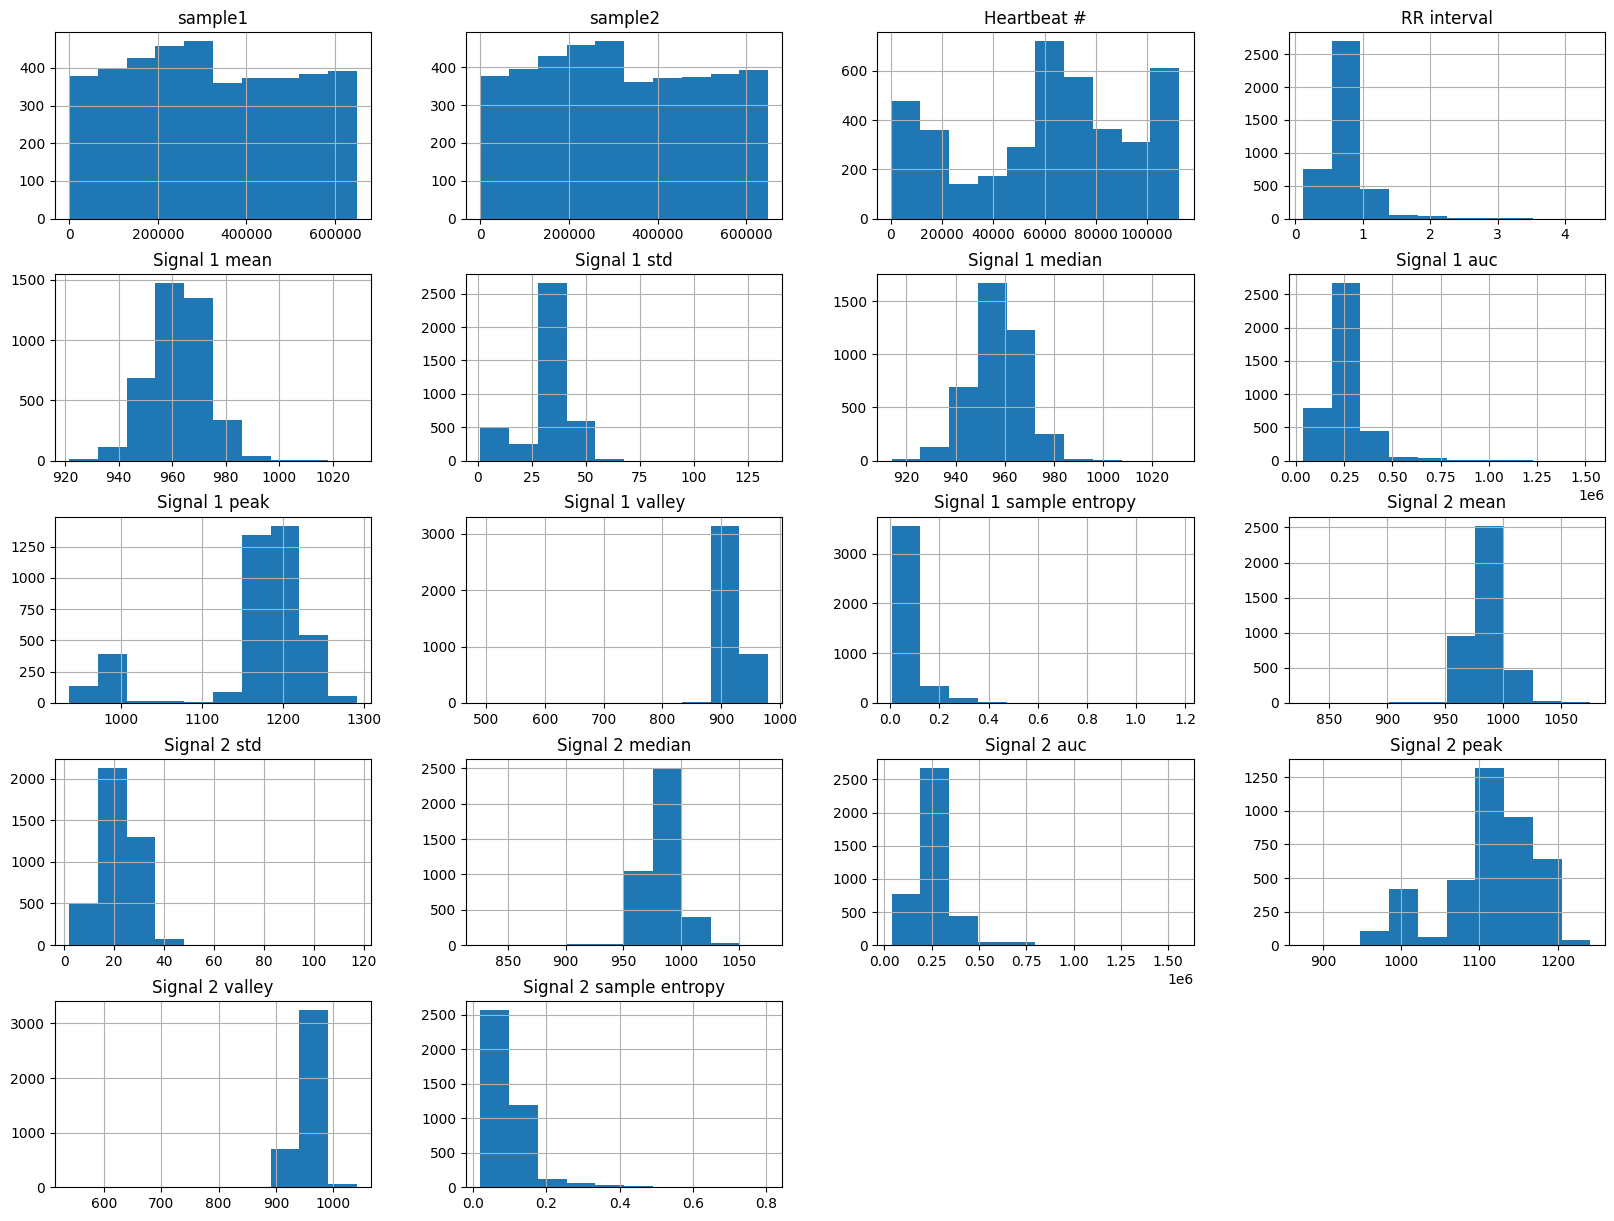

In [15]:
# Identify the majority class by finding the class with the most samples
majority_class = beat_df['Type'].value_counts().idxmax()

# Separate the majority and minority classes
majority_class_data = beat_df[beat_df['Type'] == majority_class]
minority_class_data = beat_df[beat_df['Type'] != majority_class]

# Determine the number of samples to keep for each minority class
undersampled_minority_class_size = minority_class_data['Type'].value_counts().min()

# Undersample each minority class
undersampled_minority_data = {}
for minority_class in minority_class_data['Type'].unique():
    undersampled_minority_data[minority_class] = minority_class_data[minority_class_data['Type'] == minority_class].sample(n=undersampled_minority_class_size, random_state=42)

# Undersample the majority class
undersampled_majority_data = majority_class_data.sample(n=undersampled_minority_class_size, random_state=42)

# Combine the undersampled minority and majority classes
processed_df = pd.concat([undersampled_minority_data[minority_class] for minority_class in undersampled_minority_data], axis=0)
processed_df = pd.concat([processed_df, undersampled_majority_data])

# Check the counts for each class
print(processed_df['Type'].value_counts())

processed_df.hist(figsize=(20, 15))

# Delete entries with RR interval > 5 and < 0
processed_df = processed_df[(processed_df['RR interval'] <= 5) & (processed_df['RR interval'] >= 0)]

processed_df.head()

### Scaling beat_df

In [16]:
# Scaling signals
scaler = MinMaxScaler()
Signal1mean = processed_df['Signal 1 mean'].to_numpy()
Signal1std = processed_df['Signal 1 std'].to_numpy()
Signal1median = processed_df['Signal 1 median'].to_numpy()
Signal1auc = processed_df['Signal 1 auc'].to_numpy()
Signal1peak = processed_df['Signal 1 peak'].to_numpy()
Signal1valley = processed_df['Signal 1 valley'].to_numpy()
Signal1sampleentropy = processed_df['Signal 1 sample entropy'].to_numpy()
Signal2mean = processed_df['Signal 2 mean'].to_numpy()
Signal2std = processed_df['Signal 2 std'].to_numpy()
Signal2median = processed_df['Signal 2 median'].to_numpy()
Signal2auc = processed_df['Signal 2 auc'].to_numpy()
Signal2peak = processed_df['Signal 2 peak'].to_numpy()
Signal2valley = processed_df['Signal 2 valley'].to_numpy()
Signal2sampleentropy = processed_df['Signal 2 sample entropy'].to_numpy()
RR_interval = processed_df['RR interval'].to_numpy()

processed_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
processed_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
processed_df['Signal 1 median'] = scaler.fit_transform(Signal1median.reshape(-1, 1))
processed_df['Signal 1 auc'] = scaler.fit_transform(Signal1auc.reshape(-1, 1))
processed_df['Signal 1 peak'] = scaler.fit_transform(Signal1peak.reshape(-1, 1))
processed_df['Signal 1 valley'] = scaler.fit_transform(Signal1valley.reshape(-1, 1))
processed_df['Signal 1 sample entropy'] = scaler.fit_transform(Signal1sampleentropy.reshape(-1, 1))
processed_df['Signal 2 mean'] = scaler.fit_transform(Signal2mean.reshape(-1, 1))
processed_df['Signal 2 std'] = scaler.fit_transform(Signal2std.reshape(-1, 1))
processed_df['Signal 2 median'] = scaler.fit_transform(Signal2median.reshape(-1, 1))
processed_df['Signal 2 auc'] = scaler.fit_transform(Signal2auc.reshape(-1, 1))
processed_df['Signal 2 peak'] = scaler.fit_transform(Signal2peak.reshape(-1, 1))
processed_df['Signal 2 valley'] = scaler.fit_transform(Signal2valley.reshape(-1, 1))
processed_df['Signal 2 sample entropy'] = scaler.fit_transform(Signal2sampleentropy.reshape(-1, 1))
processed_df['RR interval'] = scaler.fit_transform(RR_interval.reshape(-1, 1))

processed_df.head()

# Save processed_df to csv
processed_df.to_csv('dataframes/processed_df.csv', index=False)

## Neural Network Model

{'F': 0, 'N': 1, 'Q': 2, 'S': 3, 'V': 4}
26/26 [==============================] - 0s 2ms/step
0.572851805728518
[[137   7   1  12   4]
 [ 24  61  31  28  16]
 [  0  10 134   8   8]
 [ 18  24   8  92  19]
 [ 21  43  27  34  36]]
26/26 [==============================] - 0s 2ms/step
0.5940224159402242
[[143   5   0  11   2]
 [ 33  47  37  22  21]
 [  3   1 148   8   1]
 [ 24  15  15  92  15]
 [ 24  33  34  22  47]]
26/26 [==============================] - 0s 1ms/step
0.5927770859277709
[[146   5   1   5   3]
 [ 32  65  32  25   7]
 [  3   5 145   7   1]
 [ 21  27  14  91   8]
 [ 24  47  37  23  29]]
26/26 [==============================] - 0s 1ms/step
0.5703611457036114
[[123  10   1  17   9]
 [ 37  50  25  33  16]
 [  0   5 146   6   4]
 [ 13  22   7 102  16]
 [ 19  39  42  24  37]]
26/26 [==============================] - 0s 1ms/step
0.5877957658779577
[[133  12   4   7   5]
 [ 28  60  31  26  16]
 [  0  12 143   4   1]
 [ 15  22  11  98  14]
 [ 25  35  40  23  38]]
Mean Accuracy: 0.58


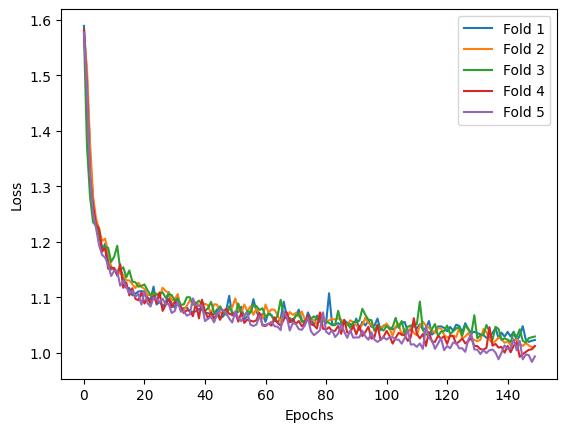

In [17]:
target_column = 'Type'
other_column_names = ['RR interval', 'Signal 1 mean', 'Signal 1 std', 'Signal 1 median', 'Signal 1 auc', 'Signal 1 peak', 'Signal 1 valley', 'Signal 1 sample entropy',
                                     'Signal 2 mean', 'Signal 2 std', 'Signal 2 median', 'Signal 2 auc', 'Signal 2 peak', 'Signal 2 valley', 'Signal 2 sample entropy']

# Encode the target variable into numerical values
le = LabelEncoder()
processed_df[target_column] = le.fit_transform(processed_df[target_column])

# Print the encoding mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Define the number of cross-validation folds
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store cross-validation scores and histories
cv_scores = []
histories = []

# Define the architecture of the deep neural network
def create_model(input_dim, num_classes):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Iterate over the cross-validation folds
for train_index, test_index in skf.split(processed_df[other_column_names], processed_df[target_column]):
    X_train, X_test = processed_df[other_column_names].iloc[train_index], processed_df[other_column_names].iloc[test_index]
    y_train, y_test = processed_df[target_column].iloc[train_index], processed_df[target_column].iloc[test_index]

    # Create and compile the model
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    model = create_model(input_dim, num_classes)

    # Train the model and store the training history
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)
    histories.append(history.history)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)
    print(fold_accuracy)
    cv_scores.append(fold_accuracy)

    # Print confusion matrix for this fold
    print(confusion_matrix(y_test, y_pred))

# Calculate the mean and standard deviation of cross-validation scores
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_accuracy:.2f}")

# Plot the loss for each fold
for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i + 1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Count y_train
print(y_train.value_counts())

# Count y_test
print(y_test.value_counts())

# Count y_pred
print(pd.Series(y_pred).value_counts())

3    643
2    643
4    642
0    642
1    642
Name: Type, dtype: int64
4    161
0    161
1    161
3    160
2    160
Name: Type, dtype: int64
2    229
0    201
3    158
1    141
4     74
dtype: int64


## Splitting dataset for train (will be subsequently balanced) and test (imbalanced - real life scenario)

In [19]:
# Split the original DataFrame into two new DataFrames
split_ratio = 0.8
num_samples = len(beat_df)

# Calculate the number of samples for the first split
split_index = int(num_samples * split_ratio)

# Shuffle the DataFrame
shuffled_df = beat_df.sample(frac=1, random_state=100)

# Split the DataFrame
train_df = shuffled_df.iloc[:split_index]
test_df = shuffled_df.iloc[split_index:]

print(num_samples)
print(len(train_df))
print(len(test_df))

109446
87556
21890


### Undersampling train_df

In [20]:
# Identify the majority class by finding the class with the most samples
majority_class = train_df['Type'].value_counts().idxmax()

# Separate the majority and minority classes
majority_class_data = train_df[train_df['Type'] == majority_class]
minority_class_data = train_df[train_df['Type'] != majority_class]

# Determine the number of samples you want to keep for each minority class
# You can set this number based on the number of samples in the smallest minority class
undersampled_minority_class_size = minority_class_data['Type'].value_counts().min()

# Undersample each minority class
undersampled_minority_data = {}
for minority_class in minority_class_data['Type'].unique():
    undersampled_minority_data[minority_class] = minority_class_data[minority_class_data['Type'] == minority_class].sample(n=undersampled_minority_class_size, random_state=42)

# Undersample the majority class
undersampled_majority_data = majority_class_data.sample(n=undersampled_minority_class_size, random_state=42)

# Combine the undersampled minority and majority classes
train_df = pd.concat([undersampled_minority_data[minority_class] for minority_class in undersampled_minority_data], axis=0)
train_df = train_df.append(undersampled_majority_data, ignore_index=True)

# Check the counts for each class
print(train_df['Type'].value_counts())

# Delete entries with RR interval > 5 and < 0
train_df = train_df[(train_df['RR interval'] <= 5) & (train_df['RR interval'] >= 0)]

train_df.head()

Q    638
V    638
S    638
F    638
N    638
Name: Type, dtype: int64


C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_26380\2400928957.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(undersampled_majority_data, ignore_index=True)


,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 auc,Signal 1 peak,Signal 1 valley,Signal 1 sample entropy,Signal 2 mean,Signal 2 std,Signal 2 median,Signal 2 auc,Signal 2 peak,Signal 2 valley,Signal 2 sample entropy,Patient,Type
0,246958,247232,9358,0.761111,977.307299,36.386787,973.8,266822.5,1213.8,932.4,0.059456,991.261314,26.719841,989.4,270624.8,1151.6,956.2,0.086645,104,Q
1,248083,248408,9362,0.902778,962.587692,33.601647,957.8,311883.7,1196.4,918.8,0.064915,986.816000,26.895637,989.2,319734.8,1156.2,952.2,0.090636,104,Q
2,188969,189246,9145,0.769444,976.890975,32.333566,973.2,269607.3,1199.6,935.8,0.056136,1003.180505,22.040912,1001.8,276870.9,1144.0,973.4,0.089043,104,Q
3,640759,641064,17640,0.847222,963.051803,36.661457,955.0,292776.8,1213.4,915.2,0.058599,1001.676066,24.606016,997.8,304516.4,1165.0,972.8,0.091701,107,Q
4,616928,617232,86068,0.844444,984.163158,41.412933,978.0,298207.3,1261.2,937.0,0.046378,1012.871711,32.116352,1008.6,306903.8,1216.4,980.0,0.070486,217,Q


### Scaling train_df

In [21]:
# Scaling signals
scaler = MinMaxScaler()
Signal1mean = train_df['Signal 1 mean'].to_numpy()
Signal1std = train_df['Signal 1 std'].to_numpy()
Signal1median = train_df['Signal 1 median'].to_numpy()
Signal1auc = train_df['Signal 1 auc'].to_numpy()
Signal1peak = train_df['Signal 1 peak'].to_numpy()
Signal1valley = train_df['Signal 1 valley'].to_numpy()
Signal1sampleentropy = train_df['Signal 1 sample entropy'].to_numpy()
Signal2mean = train_df['Signal 2 mean'].to_numpy()
Signal2std = train_df['Signal 2 std'].to_numpy()
Signal2median = train_df['Signal 2 median'].to_numpy()
Signal2auc = train_df['Signal 2 auc'].to_numpy()
Signal2peak = train_df['Signal 2 peak'].to_numpy()
Signal2valley = train_df['Signal 2 valley'].to_numpy()
Signal2sampleentropy = train_df['Signal 2 sample entropy'].to_numpy()
RR_interval = train_df['RR interval'].to_numpy()

train_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
train_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
train_df['Signal 1 median'] = scaler.fit_transform(Signal1median.reshape(-1, 1))
train_df['Signal 1 auc'] = scaler.fit_transform(Signal1auc.reshape(-1, 1))
train_df['Signal 1 peak'] = scaler.fit_transform(Signal1peak.reshape(-1, 1))
train_df['Signal 1 valley'] = scaler.fit_transform(Signal1valley.reshape(-1, 1))
train_df['Signal 1 sample entropy'] = scaler.fit_transform(Signal1sampleentropy.reshape(-1, 1))
train_df['Signal 2 mean'] = scaler.fit_transform(Signal2mean.reshape(-1, 1))
train_df['Signal 2 std'] = scaler.fit_transform(Signal2std.reshape(-1, 1))
train_df['Signal 2 median'] = scaler.fit_transform(Signal2median.reshape(-1, 1))
train_df['Signal 2 auc'] = scaler.fit_transform(Signal2auc.reshape(-1, 1))
train_df['Signal 2 peak'] = scaler.fit_transform(Signal2peak.reshape(-1, 1))
train_df['Signal 2 valley'] = scaler.fit_transform(Signal2valley.reshape(-1, 1))
train_df['Signal 2 sample entropy'] = scaler.fit_transform(Signal2sampleentropy.reshape(-1, 1))
train_df['RR interval'] = scaler.fit_transform(RR_interval.reshape(-1, 1))

# Save train_df to csv
train_df.to_csv('dataframes/train_df.csv', index=False)

train_df.head()

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 auc,Signal 1 peak,Signal 1 valley,Signal 1 sample entropy,Signal 2 mean,Signal 2 std,Signal 2 median,Signal 2 auc,Signal 2 peak,Signal 2 valley,Signal 2 sample entropy,Patient,Type
0,246958,247232,9358,0.144772,0.498095,0.265634,0.513739,0.146774,0.781603,0.902817,0.039814,0.663660,0.215424,0.667492,0.145123,0.754214,0.834135,0.083941,104,Q
1,248083,248408,9362,0.178954,0.367047,0.244570,0.380516,0.178055,0.732506,0.875051,0.044508,0.644720,0.216969,0.666667,0.178377,0.766721,0.826122,0.089476,104,Q
2,188969,189246,9145,0.146783,0.494388,0.234980,0.508743,0.148707,0.741535,0.909759,0.036960,0.714442,0.174310,0.718647,0.149353,0.733551,0.868590,0.087267,104,Q
3,640759,641064,17640,0.165550,0.371179,0.267711,0.357202,0.164791,0.780474,0.867701,0.039078,0.708032,0.196850,0.702145,0.168072,0.790647,0.867388,0.090953,107,Q
4,616928,617232,86068,0.164879,0.559132,0.303645,0.548709,0.168561,0.915350,0.912209,0.028571,0.755732,0.262843,0.746700,0.169689,0.930397,0.881811,0.061533,217,Q


### Scaling test_df

In [22]:
# Scaling signals
scaler = MinMaxScaler()
Signal1mean = test_df['Signal 1 mean'].to_numpy()
Signal1std = test_df['Signal 1 std'].to_numpy()
Signal1median = test_df['Signal 1 median'].to_numpy()
Signal1auc = test_df['Signal 1 auc'].to_numpy()
Signal1peak = test_df['Signal 1 peak'].to_numpy()
Signal1valley = test_df['Signal 1 valley'].to_numpy()
Signal1sampleentropy = test_df['Signal 1 sample entropy'].to_numpy()
Signal2mean = test_df['Signal 2 mean'].to_numpy()
Signal2std = test_df['Signal 2 std'].to_numpy()
Signal2median = test_df['Signal 2 median'].to_numpy()
Signal2auc = test_df['Signal 2 auc'].to_numpy()
Signal2peak = test_df['Signal 2 peak'].to_numpy()
Signal2valley = test_df['Signal 2 valley'].to_numpy()
Signal2sampleentropy = test_df['Signal 2 sample entropy'].to_numpy()
RR_interval = test_df['RR interval'].to_numpy()

test_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
test_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
test_df['Signal 1 median'] = scaler.fit_transform(Signal1median.reshape(-1, 1))
test_df['Signal 1 auc'] = scaler.fit_transform(Signal1auc.reshape(-1, 1))
test_df['Signal 1 peak'] = scaler.fit_transform(Signal1peak.reshape(-1, 1))
test_df['Signal 1 valley'] = scaler.fit_transform(Signal1valley.reshape(-1, 1))
test_df['Signal 1 sample entropy'] = scaler.fit_transform(Signal1sampleentropy.reshape(-1, 1))
test_df['Signal 2 mean'] = scaler.fit_transform(Signal2mean.reshape(-1, 1))
test_df['Signal 2 std'] = scaler.fit_transform(Signal2std.reshape(-1, 1))
test_df['Signal 2 median'] = scaler.fit_transform(Signal2median.reshape(-1, 1))
test_df['Signal 2 auc'] = scaler.fit_transform(Signal2auc.reshape(-1, 1))
test_df['Signal 2 peak'] = scaler.fit_transform(Signal2peak.reshape(-1, 1))
test_df['Signal 2 valley'] = scaler.fit_transform(Signal2valley.reshape(-1, 1))
test_df['Signal 2 sample entropy'] = scaler.fit_transform(Signal2sampleentropy.reshape(-1, 1))
test_df['RR interval'] = scaler.fit_transform(RR_interval.reshape(-1, 1))

# Save test_df to csv
test_df.to_csv('dataframes/test_df.csv', index=False)

test_df.head()

C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_26380\1450014240.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Signal 1 mean'] = scaler.fit_transform(Signal1mean.reshape(-1, 1))
C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_26380\1450014240.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Signal 1 std'] = scaler.fit_transform(Signal1std.reshape(-1, 1))
C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_26380\1450014240.py:21: SettingWithCopyWarning: 
A value is trying to be se

,sample1,sample2,Heartbeat #,RR interval,Signal 1 mean,Signal 1 std,Signal 1 median,Signal 1 auc,Signal 1 peak,Signal 1 valley,Signal 1 sample entropy,Signal 2 mean,Signal 2 std,Signal 2 median,Signal 2 auc,Signal 2 peak,Signal 2 valley,Signal 2 sample entropy,Patient,Type
54188,427161,427338,54188,0.075651,0.236952,0.283182,0.210485,0.072764,0.660970,0.815738,0.055847,0.634477,0.184000,0.620936,0.074697,0.653733,0.825948,0.055920,202,N
13115,575662,575905,13115,0.108717,0.263850,0.191807,0.299444,0.105098,0.716648,0.842618,0.079546,0.609762,0.066203,0.611420,0.106648,0.505403,0.818363,0.159970,105,N
105193,98922,99180,105193,0.116232,0.458200,0.270150,0.455123,0.115598,0.771775,0.853915,0.043615,0.643135,0.240607,0.626487,0.115184,0.794204,0.815968,0.031177,232,S
24567,101917,102166,24567,0.111723,0.342256,0.228810,0.375695,0.109306,0.648291,0.832879,0.034986,0.611179,0.174163,0.621729,0.109654,0.643418,0.801996,0.024828,112,N
23355,408466,408777,23355,0.142786,0.307145,0.222486,0.332804,0.139072,0.706725,0.836385,0.057051,0.636836,0.155931,0.630452,0.141283,0.684185,0.818363,0.042893,111,N


### Neural Network Model using train_df and test_df

{'F': 0, 'N': 1, 'Q': 2, 'S': 3, 'V': 4}
Epoch 1/150


C:\Users\AndreLopes\AppData\Local\Temp\ipykernel_26380\651927565.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target_column] = le.fit_transform(test_df[target_column])


100/100 [==============================] - 1s 2ms/step - loss: 1.5877 - accuracy: 0.2418
Epoch 2/150
100/100 [==============================] - 0s 2ms/step - loss: 1.4470 - accuracy: 0.3779
Epoch 3/150
100/100 [==============================] - 0s 2ms/step - loss: 1.2931 - accuracy: 0.4788
Epoch 4/150
100/100 [==============================] - 0s 2ms/step - loss: 1.2473 - accuracy: 0.4980
Epoch 5/150
100/100 [==============================] - 0s 2ms/step - loss: 1.2334 - accuracy: 0.5064
Epoch 6/150
100/100 [==============================] - 0s 2ms/step - loss: 1.1960 - accuracy: 0.5312
Epoch 7/150
100/100 [==============================] - 0s 2ms/step - loss: 1.1727 - accuracy: 0.5400
Epoch 8/150
100/100 [==============================] - 0s 2ms/step - loss: 1.1564 - accuracy: 0.5450
Epoch 9/150
100/100 [==============================] - 0s 2ms/step - loss: 1.1613 - accuracy: 0.5375
Epoch 10/150
100/100 [==============================] - 0s 2ms/step - loss: 1.1614 - accuracy: 0.5372
E

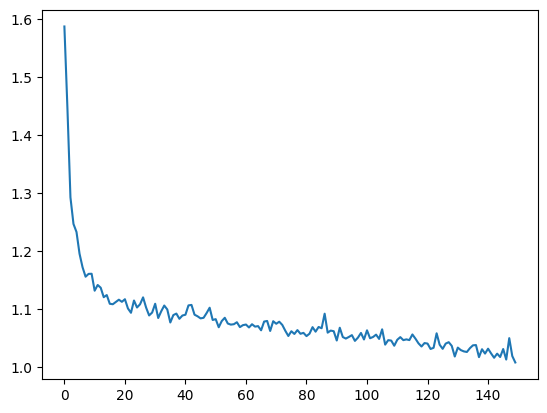

In [23]:
# Create and compile the Sequential model
model = keras.Sequential()
model.add(layers.Input(shape=(input_dim,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

target_column = 'Type'
other_column_names = ['RR interval', 'Signal 1 mean', 'Signal 1 std', 'Signal 1 median', 'Signal 1 auc', 'Signal 1 peak', 'Signal 1 valley', 'Signal 1 sample entropy',
                                     'Signal 2 mean', 'Signal 2 std', 'Signal 2 median', 'Signal 2 auc', 'Signal 2 peak', 'Signal 2 valley', 'Signal 2 sample entropy']

# Encode the target variable into numerical values
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])
test_df[target_column] = le.fit_transform(test_df[target_column])

# Print the encoding mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))

# Assign X_train and y_train from train_df
X_train = train_df[other_column_names]
y_train = train_df[target_column]

# Assign X_test and y_test from test_df
X_test = test_df[other_column_names]
y_test = test_df[target_column]

# Fit the model to your training data
history = model.fit(X_train, y_train, epochs=150, batch_size=32)  

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Plot the loss function
plt.plot(history.history['loss'])

In [24]:
# Print the count of each predicted class
print(pd.Series(y_pred).value_counts())

cm = confusion_matrix(y_test, y_pred)
print(cm)

1    7258
0    5068
3    4827
2    3886
4     851
dtype: int64
[[ 144    7    1   10    3]
 [4577 6467 3391 3127  526]
 [  25  134  190 1285    5]
 [  71  268   40  125   53]
 [ 251  382  264  280  264]]
